# Gravitational wave detection
Chrisopher Bresten and Jae-Hun Jung propose to include topological features in a CNN classifier for gravitational waves detection. Adapted from their article, this notebook showcases an application of ideas from the [Topology of time series example](https://giotto-ai.github.io/gtda-docs/latest/notebooks/topology_time_series.html).

If you are looking at a static version of this notebook and would like to run its contents, head over to [GitHub](https://github.com/giotto-ai/giotto-tda/blob/master/examples/gravitational_waves_detection.ipynb) and download the source.

## Useful references

* [Topology of time series](https://giotto-ai.github.io/gtda-docs/latest/notebooks/topology_time_series.html), in which the *Takens embedding* technique used here is explained in detail and illustrated via simple examples.
* [Detection of gravitational waves using topological data analysis and convolutional neural network: An improved approach](https://arxiv.org/abs/1910.08245) by Christopher Bresten and Jae-Hun Jung. We thank Christopher Bresten for sharing the code and data used in the article.

## See also

- [Topology in time series forecasting](https://giotto-ai.github.io/gtda-docs/latest/notebooks/time_series_forecasting.html), in which the Takens embedding technique is used in time series forecasting tasks by using sliding windows.
- [Topological feature extraction using VietorisRipsPersistence and PersistenceEntropy](https://giotto-ai.github.io/gtda-docs/latest/notebooks/vietoris_rips_quickstart.html) for a quick introduction to general topological feature extraction in ``giotto-tda``.

**License: AGPLv3**

## Motivation
The videos below show different representations of the gravitational waves that we aim to detect. We will aim to pick out the "chirp" signal of two colliding black holes from a very noisy backgound.

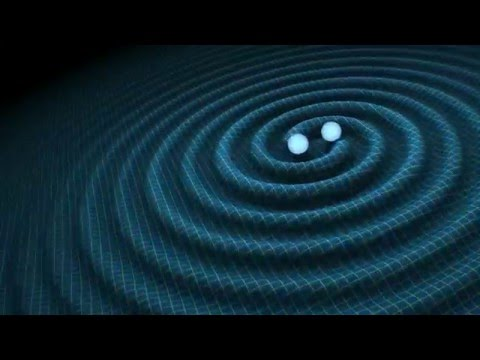

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo("Y3eR49ogsF0", width=600, height=400)

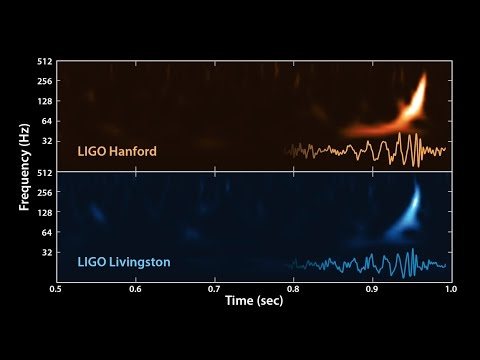

In [2]:
YouTubeVideo("QyDcTbR-kEA", width=600, height=400)

## Setup

In [3]:
pip install -U giotto-tda

     |████████████████████████████████| 1.5 MB 651 kB/s 
     |████████████████████████████████| 404 kB 33.1 MB/s 
     |████████████████████████████████| 38.1 MB 1.4 MB/s 
     |████████████████████████████████| 3.1 MB 32.5 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import sys
sys.path.append('/content/drive/Shareddrives/Geometría y Topología')

## Generate the data

In the article, the authors create a synthetic training set as follows: 

* Generate gravitational wave signals that correspond to non-spinning binary black hole mergers
* Generate a noisy time series and embed a gravitational wave signal with probability 0.5 at a random time.

The result is a set of time series of the form

$$ s = g + \epsilon \frac{1}{R}\xi $$

where $g$ is a gravitational wave signal from the reference set, $\xi$ is Gaussian noise, $\epsilon=10^{-19}$ scales the noise amplitude to the signal, and $R \in (0.075, 0.65)$ is a parameter that controls the signal-to-noise-ratio (SNR).

## Constant signal-to-noise ratio

As a warmup, let's generate some noisy signals with a constant SNR of 17.98. As shown in Table 1 of the article, this corresponds to an $R$ value of 0.65. By picking the upper end of the interval, we place ourselves in a favorable scenario and, thus, can gain a sense for what the best possible performance is for our time series classifier. We pick a small number of samples to make the computations run fast, but in practice would scale this by 1-2 orders of magnitude as done in the original article.

In [6]:
from data.generate_datasets import make_gravitational_waves
from pathlib import Path

R = 0.65
n_signals = 100
DATA = Path("/content/drive/Shareddrives/Geometría y Topología/data")

noisy_signals, gw_signals, labels = make_gravitational_waves(
    path_to_data=DATA, n_signals=n_signals, r_min=R, r_max=R, n_snr_values=1
)

print(f"Number of noisy signals: {len(noisy_signals)}")
print(f"Number of timesteps per series: {len(noisy_signals[0])}")

Number of noisy signals: 100
Number of timesteps per series: 8692


Next let's visualise the two different types of time series that we wish to classify: one that is pure noise vs. one that is composed of noise plus an embedded gravitational wave signal:

In [7]:
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# get the index corresponding to the first pure noise time series
background_idx = np.argmin(labels)
# get the index corresponding to the first noise + gravitational wave time series
signal_idx = np.argmax(labels)

ts_noise = noisy_signals[background_idx]
ts_background = noisy_signals[signal_idx]
ts_signal = gw_signals[signal_idx]

fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=list(range(len(ts_noise))), y=ts_noise, mode="lines", name="noise"),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=list(range(len(ts_background))),
        y=ts_background,
        mode="lines",
        name="background",
    ),
    row=1,
    col=2,
)

fig.add_trace(
    go.Scatter(x=list(range(len(ts_signal))), y=ts_signal, mode="lines", name="signal"),
    row=1,
    col=2,
)
fig.show()

We make two observations:
1. It is hard to distinguish the signal by eye,
2. The signal features some regularity or periodicity.

Both observations lead us to examining the _**Takens embedding**_ of the signal $s(t)$, in order to pick up the recurrent structure. Indeed, if $f$ is sampled from a dynamical system with a non-trivial recurrent structure, then, for appropriate parameters, the image by the embedding will have non-trivial topology.

More formally,, we extract a sequence of vectors in $\mathbb{R}^{d}$ of the form

$$
TD_{d,\tau} s : \mathbb{R} \to \mathbb{R}^{d}\,, \qquad t \to \begin{bmatrix}
           s(t) \\
           s(t + \tau) \\
           s(t + 2\tau) \\
           \vdots \\
           s(t + (d-1)\tau)
         \end{bmatrix},
$$
where $d$ is the embedding dimension and $\tau$ is the time delay. The quantity $(d-1)\tau$ is known as the "window size" and the difference between $t_{i+1}$ and $t_i$ is called the stride.

Let's examine what the time delay embedding of a pure gravitational wave signal looks like:

In [8]:
from gtda.time_series import SingleTakensEmbedding
embedding_dimension = 30
embedding_time_delay = 30
stride = 5

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_gw_embedded = embedder.fit_transform(gw_signals[0])

We can use PCA to project our high-dimensional space to 3-dimensions for visualisation:

In [9]:
from sklearn.decomposition import PCA
from gtda.plotting import plot_point_cloud

pca = PCA(n_components=3)
y_gw_embedded_pca = pca.fit_transform(y_gw_embedded)

plot_point_cloud(y_gw_embedded_pca)

From the plot we can see that the decaying periodic signal generated by a black hole merger emerges as a _spiral_ in the time delay embedding space! For contrast, let's compare this to one of the pure noise time series in our sample:

In [10]:
embedding_dimension = 30
embedding_time_delay = 30
stride = 5

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_noise_embedded = embedder.fit_transform(noisy_signals[background_idx])

pca = PCA(n_components=3)
y_noise_embedded_pca = pca.fit_transform(y_noise_embedded)

plot_point_cloud(y_noise_embedded_pca)

Evidently, pure noise resembles a high-dimensional ball in the time delay embedding space. Let's see if we can use persistent homology to tease apart which time series contain a gravitational wave signal versus those that don't. To do so we will adapt the strategy from the original article:

1. Generate 200-dimensional time delay embeddings of each time series
2. Use PCA to reduce the time delay embeddings to 3-dimensions
3. Use the Vietoris-Rips construction to calculate persistence diagrams of $H_0$ and $H_1$ generators
4. Extract feature vectors using persistence entropy
5. Train a binary classifier on the topological features

### Define the topological feature generation pipeline

We can do steps 1 and 2 by using the following ``giotto-tda`` tools:

- The ``TakensEmbedding`` transformer – instead of ``SingleTakensEmbedding`` – which will transform each time series in ``noisy_signals`` separately and return a collection of point clouds;
- ``CollectionTransformer``, which is a convenience "meta-estimator" for applying the same PCA to each point cloud resulting from step 1.

Using the ``Pipeline`` class from ``giotto-tda``, we can chain all operations up to and including step 4 as follows:

In [11]:
from gtda.diagrams import PersistenceEntropy, Scaler
from gtda.homology import VietorisRipsPersistence
from gtda.metaestimators import CollectionTransformer
from gtda.pipeline import Pipeline
from gtda.time_series import TakensEmbedding

embedding_dimension = 200
embedding_time_delay = 10
stride = 10

embedder = TakensEmbedding(time_delay=embedding_time_delay,
                           dimension=embedding_dimension,
                           stride=stride)

batch_pca = CollectionTransformer(PCA(n_components=3), n_jobs=-1)

persistence = VietorisRipsPersistence(homology_dimensions=[0, 1], n_jobs=-1)

scaling = Scaler()

entropy = PersistenceEntropy(normalize=True, nan_fill_value=-10)


steps = [("embedder", embedder),
         ("pca", batch_pca),
         ("persistence", persistence),
         ("scaling", scaling),
         ("entropy", entropy)]
topological_transfomer = Pipeline(steps)

In [12]:
features = topological_transfomer.fit_transform(noisy_signals)

## Train and evaluate models

For the final step, let's train a simple classifier on our topological features. As usual we create training and validation sets, fit and evaluate our model

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.linear_model import LogisticRegression

### Train and evaluate a logistic regression model

In [14]:
def print_scores_sklearn(fitted_model, X_train, X_valid, y_train, y_valid):
    res = {
        "Accuracy on train:": accuracy_score(fitted_model.predict(X_train), y_train),
        "ROC AUC on train:": roc_auc_score(
            y_train, fitted_model.predict_proba(X_train)[:, 1]
        ),
        "Accuracy on valid:": accuracy_score(fitted_model.predict(X_valid), y_valid),
        "ROC AUC on valid:": roc_auc_score(
            y_valid, fitted_model.predict_proba(X_valid)[:, 1]
        ),
    }

    for k, v in res.items():
        print(k, round(v, 3))

In [15]:
def train_evaluate_lrmodel(X_type, y):

    if X_type == 'raw':
        X = noisy_signals
    elif X_type == 'tda':
        X = features
    elif X_type == 'both':
        X = np.hstack((noisy_signals,features))

    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.1, random_state=42
    )

    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    print_scores_sklearn(model, X_train, X_valid, y_train, y_valid)

#### Raw data

In [16]:
train_evaluate_lrmodel(X_type='raw', y=labels)

Accuracy on train: 0.567
ROC AUC on train: 0.5
Accuracy on valid: 0.5
ROC AUC on valid: 0.5


#### Topological features data

In [17]:
train_evaluate_lrmodel(X_type='tda', y=labels)

Accuracy on train: 0.689
ROC AUC on train: 0.829
Accuracy on valid: 0.8
ROC AUC on valid: 0.92


#### Both raw and tda features data

In [18]:
train_evaluate_lrmodel(X_type='both', y=labels)

Accuracy on train: 0.689
ROC AUC on train: 0.829
Accuracy on valid: 0.8
ROC AUC on valid: 0.92


As a simple baseline, this model is not too bad - it outperforms the deep learning baseline in the article which typically fares little better than random on the raw data. However, the combination of deep learning and persistent homology is where significant performance gains are seen - we leave this as an exercise to the intrepid reader!

### Train and evaluate a convolutional neural network model

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

import tensorflow as tf

from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

### Train and evaluate a logistic regression model

In [20]:
def print_scores_keras(fitted_model, X_train, X_valid, y_train, y_valid):
    res = {
        "Loss on train:": fitted_model.evaluate(X_train,  y_train, verbose=0),
        "Accuracy on train:": fitted_model.evaluate(X_train,  y_train, verbose=0),
        "Loss on valid:": fitted_model.evaluate(X_valid,  y_valid, verbose=0),
        "Accuracy on valid:": fitted_model.evaluate(X_valid,  y_valid, verbose=0)
    }

    for k, v in res.items():
        print(k, round(v, 3))

In [21]:
np.array(noisy_signals).shape

(100, 8692)

In [27]:
def train_evaluate_cnnmodel(X_type, y):

    if X_type == 'raw':
        X = noisy_signals
    elif X_type == 'tda':
        X = features
    elif X_type == 'both':
        X = np.hstack((noisy_signals,features))

    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    model = models.Sequential()
    model.add(layers.Reshape((8692,1), input_shape=(8692,)))
    model.add(layers.Conv1D(64, strides=1, kernel_size=16, dilation_rate=1, kernel_initializer=tf.keras.initializers.Orthogonal()))
    model.add(layers.MaxPooling1D(strides=4, pool_size=4))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Conv1D(128, strides=1, kernel_size=16, dilation_rate=2))
    model.add(layers.MaxPooling1D(strides=4, pool_size=4))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Conv1D(256, strides=1, kernel_size=16, dilation_rate=2))
    model.add(layers.MaxPooling1D(strides=4, pool_size=4))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Conv1D(512, strides=1, kernel_size=32, dilation_rate=2))
    model.add(layers.MaxPooling1D(strides=4, pool_size=4))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='linear'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='linear'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(2, activation='linear'))
    model.add(layers.Dense(2, activation='softmax'))

    model.summary()

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=['accuracy'])
  
    
    history = model.fit(tf.stack(X_train), tf.stack(y_train), epochs=5, 
                        validation_data=(tf.stack(X_valid), tf.stack(y_valid)))
    
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')

    print_scores_keras(model, X_train, X_valid, y_train, y_valid)

#### Raw data

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 8692, 1)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 8677, 64)          1088      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 2169, 64)         0         
 1D)                                                             
                                                                 
 dense_10 (Dense)            (None, 2169, 64)          4160      
                                                                 
 conv1d_6 (Conv1D)           (None, 2139, 128)         131200    
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 534, 128)         0         
 1D)                                                  

ValueError: ignored

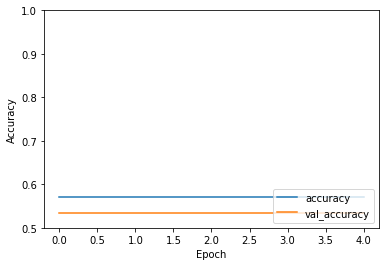

In [28]:
train_evaluate_cnnmodel(X_type='raw', y=labels)

#### Topological features data

In [ ]:
train_evaluate_lrmodel(X_type='tda', y=labels)

Accuracy on train: 0.622
ROC AUC on train: 0.713
Accuracy on valid: 0.5
ROC AUC on valid: 0.833


#### Both raw and tda features data

In [ ]:
train_evaluate_lrmodel(X_type='both', y=labels)

Accuracy on train: 0.622
ROC AUC on train: 0.713
Accuracy on valid: 0.5
ROC AUC on valid: 0.833
